In [86]:
from itertools import product
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.io import loadmat
from statsmodels.graphics.tsaplots import plot_pacf

import adaptive_filters

In [87]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [24, 9]

In [88]:
dados_ruido_gaussiano = loadmat('dados_identificacao_ruido_gaussiano.mat')
dados_ruido_impulsivo = loadmat('dados_identificacao_ruido_impulsivo.mat')
dados_ex2 = loadmat('ex_2.mat')

## 1.A: Solução de Wiener com 2 parâmetros

In [89]:
x = dados_ruido_gaussiano['x'].reshape(-1)
d = dados_ruido_gaussiano['d'].reshape(-1)

In [90]:
def estimate_signal(entry_signal, output_signal, num_parameters):
    lag_zero = entry_signal.shape[0] - 1
    r_x = np.correlate(entry_signal, entry_signal, 'full')[lag_zero : lag_zero + num_parameters]
    p_xd = np.correlate(output_signal, entry_signal, 'full')[lag_zero : lag_zero + num_parameters]

    inv_corr_mat = scipy.linalg.inv(scipy.linalg.toeplitz(r_x))

    optimal_params = inv_corr_mat @ p_xd
    print("Solução de Wiener com 2 parâmetros:", optimal_params)
    
    estimate = np.convolve(entry_signal, optimal_params, 'full')[:entry_signal.shape[0]]
    
    return estimate

Solução de Wiener com 2 parâmetros: [1.01479833 0.22752558]


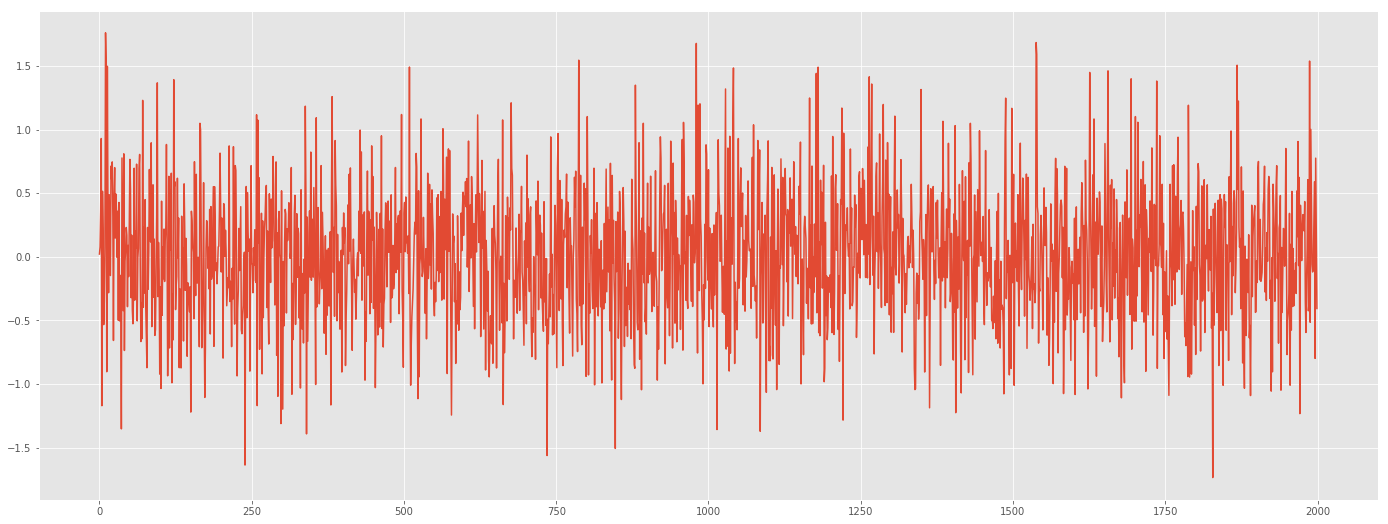

In [91]:
plt.plot(d - estimate_signal(x, d, 2))

## 1.B: Algoritmos LMS, do Sinal do Erro e RLS

### 1.B.i: LMS

In [92]:
def sqr_error(weights, R, p):
    weights = np.array(weights).reshape(-1)
    var = 1
    p_xd = p.reshape(-1)
    
    return var - 2 * weights.T @ p_xd + weights.T @ R @ weights

In [93]:
def make_error_contours(x, d, weight_history):
    w0 = np.linspace(-.1, 1.2, 100)

    lag_zero = x.shape[0] - 1
    p_xd = np.correlate(d, x, 'full')[lag_zero : lag_zero + 2]
    r_x = np.correlate(x, x, 'full')[lag_zero : lag_zero + 2]
    R = scipy.linalg.toeplitz(r_x)

    points = list(product(w0, repeat=2))
    errors = np.array([sqr_error(point, R, p_xd) for point in points])

    xx = np.array([point[0] for point in points])
    yy = np.array([point[1] for point in points])
    
    plt.contourf(w0, w0, errors.reshape(w0.shape[0], -1), cmap='coolwarm_r', levels=100)
    plt.contour(w0, w0, errors.reshape(w0.shape[0], -1), cmap='RdBu', levels=100)

    trajectory_x = [point[0] for point in weight_history]
    trajectory_y = [point[1] for point in weight_history]
    plt.scatter(trajectory_y, trajectory_x, c='k', marker='^', label='Weight History')
    plt.scatter(trajectory_y[-1], trajectory_x[-1], c='white', marker='o', label='Last Weights Calculated')
    plt.scatter(0.22752558, 1.01479833, c='y', marker='x', label='Optimal')

    plt.legend()
    plt.xlabel('W1')
    plt.ylabel('W0')

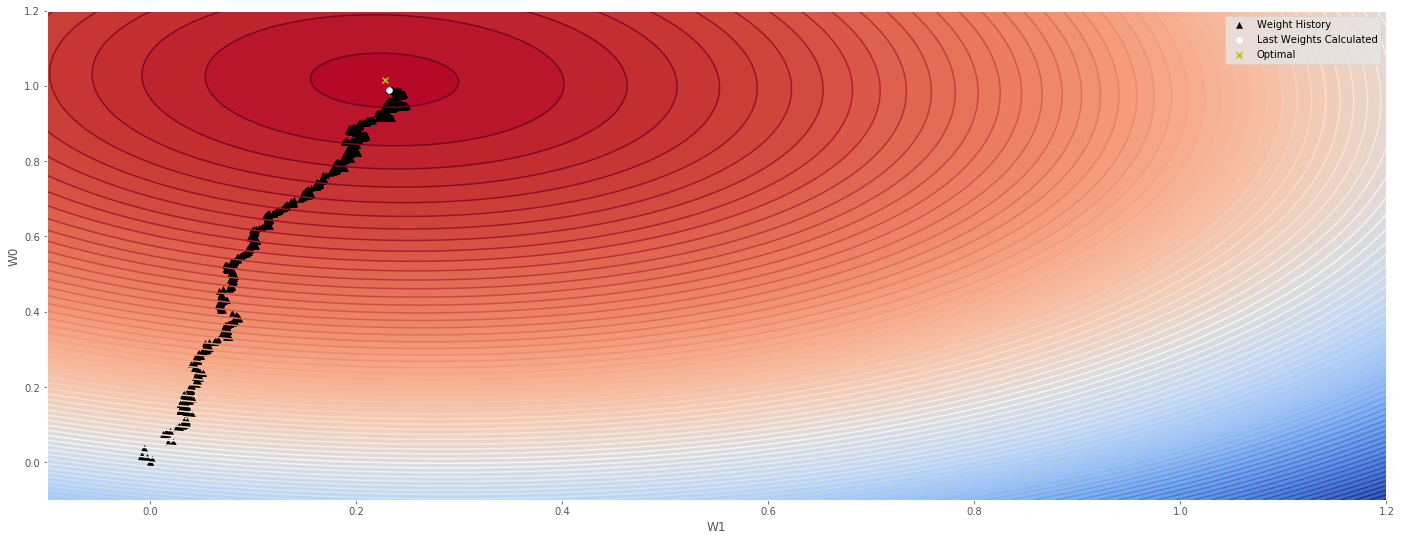

In [94]:
pace = 7 / (2 * np.correlate(x, x, 'valid'))
lms_estimate, lms_weight_history = adaptive_filters.lms(x, d, 2, pace=pace)
make_error_contours(x, d, lms_weight_history)

### 1.B.ii: Sinal do Erro

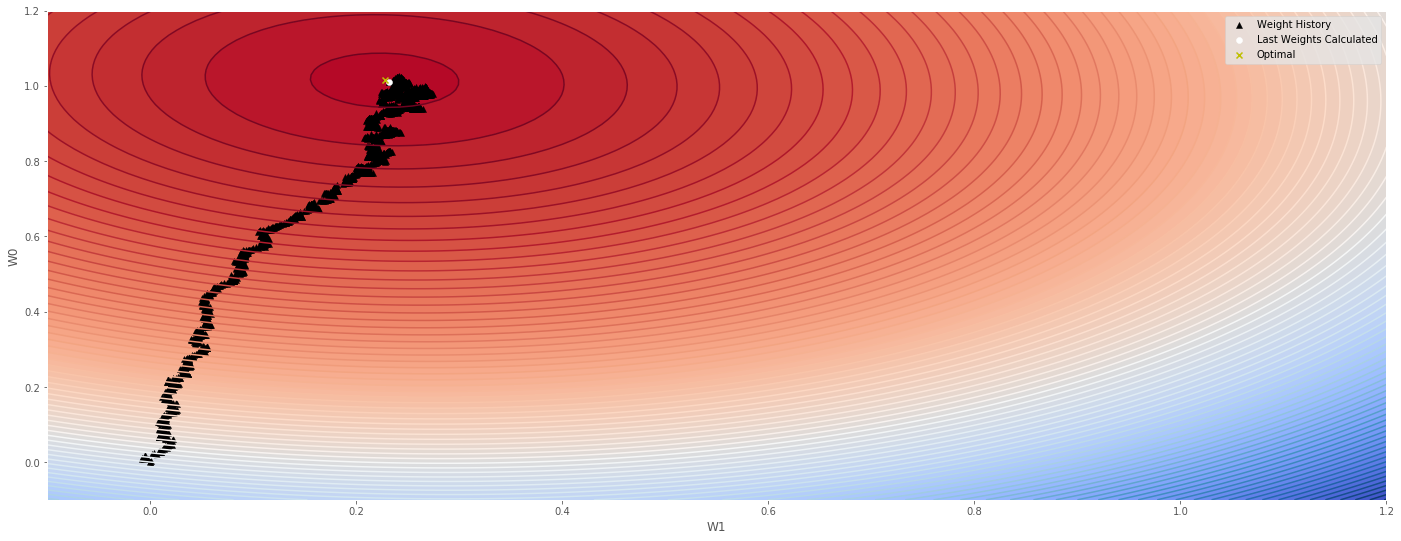

In [95]:
pace = 7 / (2 * np.correlate(x, x, 'valid'))
es_estimate, es_weight_history = adaptive_filters.error_signal_lms(x, d, 2, pace=pace)
make_error_contours(x, d, es_weight_history)

## 1.B.iii: RLS

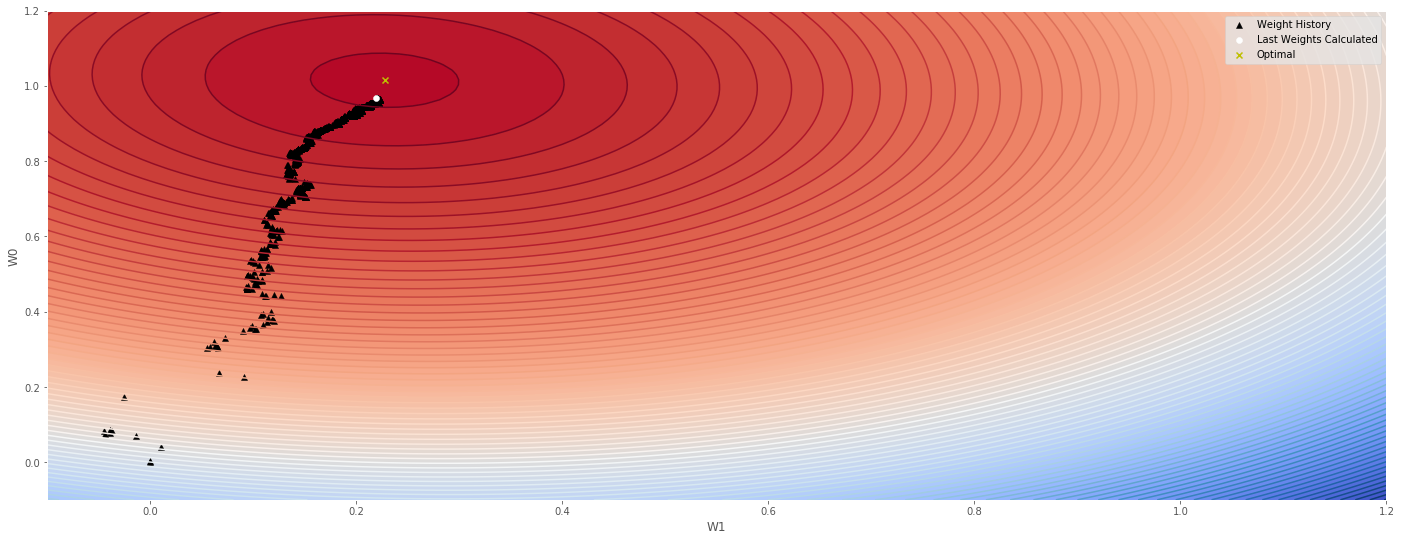

In [98]:
rls_estimate, rls_weight_history = adaptive_filters.rls(x, d, 2, 1, 0)
make_error_contours(x, d, rls_weight_history)

## 1.C: Evolução do Erro Quadrático Instantâneo

### 1.C.i: LMS

In [63]:
lms_sqr_error = np.power(d - lms_estimate, 2)

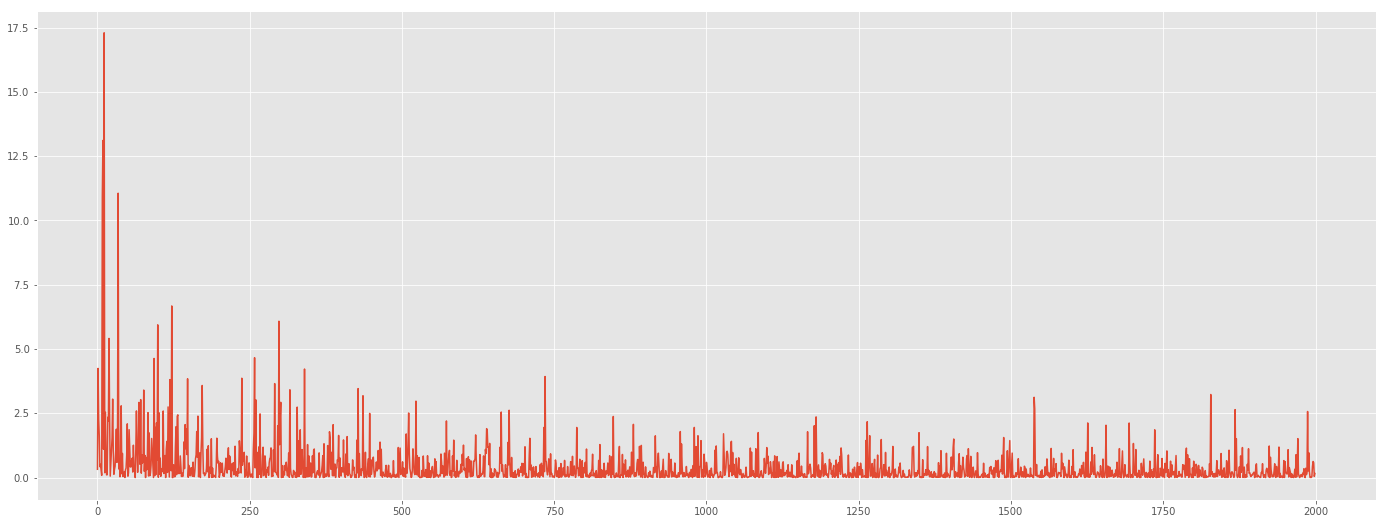

In [64]:
plt.plot(range(lms_sqr_error.shape[0]), lms_sqr_error)

### 1.C.ii: Sinal do Erro

In [65]:
es_sqr_error = np.power(d - es_estimate, 2)

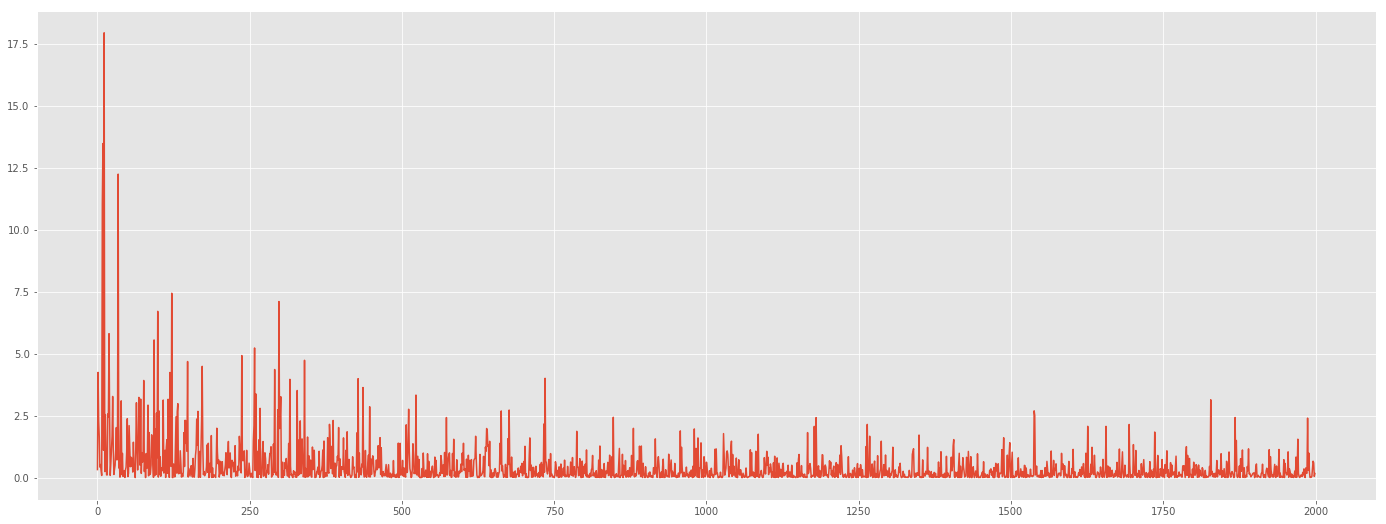

In [66]:
plt.plot(range(es_sqr_error.shape[0]), es_sqr_error)

### 1.C.iii: RLS

In [67]:
rls_sqr_error = np.power(d - rls_estimate, 2)

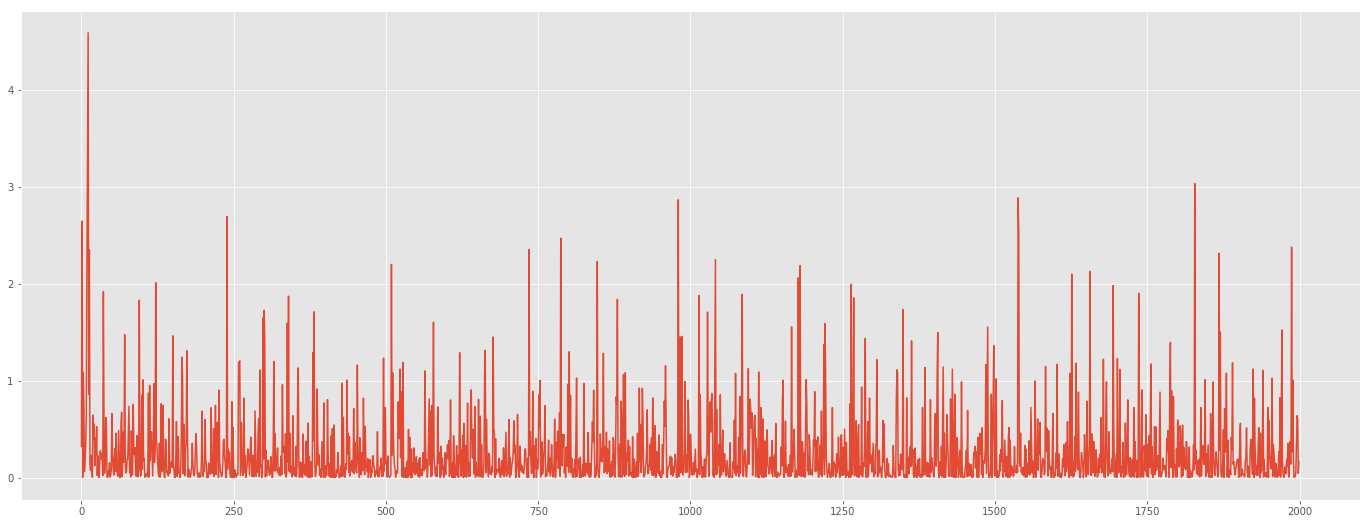

In [68]:
plt.plot(range(rls_sqr_error.shape[0]), rls_sqr_error)

## 1.D: Evolução dos Coeficientes com o Número de Iterações

In [69]:
num_samples = x.shape[0]

### 1.D.i: LMS

In [70]:
xs = [p[0] for p in lms_weight_history]
ys = [p[1] for p in lms_weight_history]

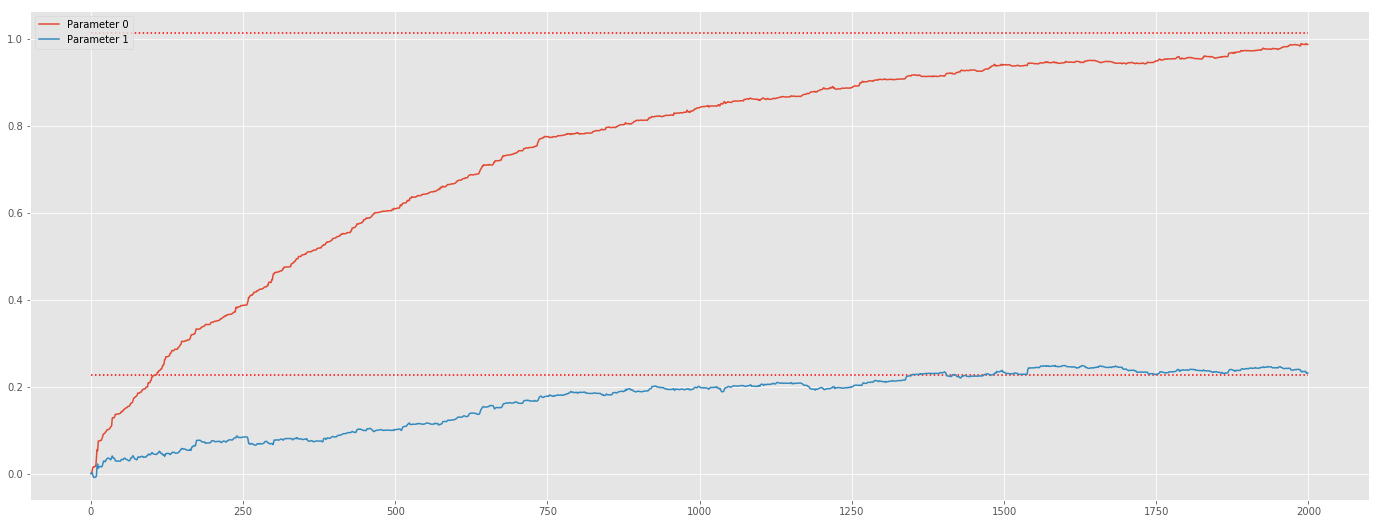

In [71]:
plt.plot(range(num_samples), xs, label="Parameter 0")
plt.plot(range(num_samples), ys, label="Parameter 1")
plt.hlines([1.01479833, 0.22752558], xmin=0, xmax=2000, linestyle=':', color='r')
plt.legend()

### 1.D.ii: Sinal do Erro

In [72]:
xs = [p[0] for p in es_weight_history]
ys = [p[1] for p in es_weight_history]

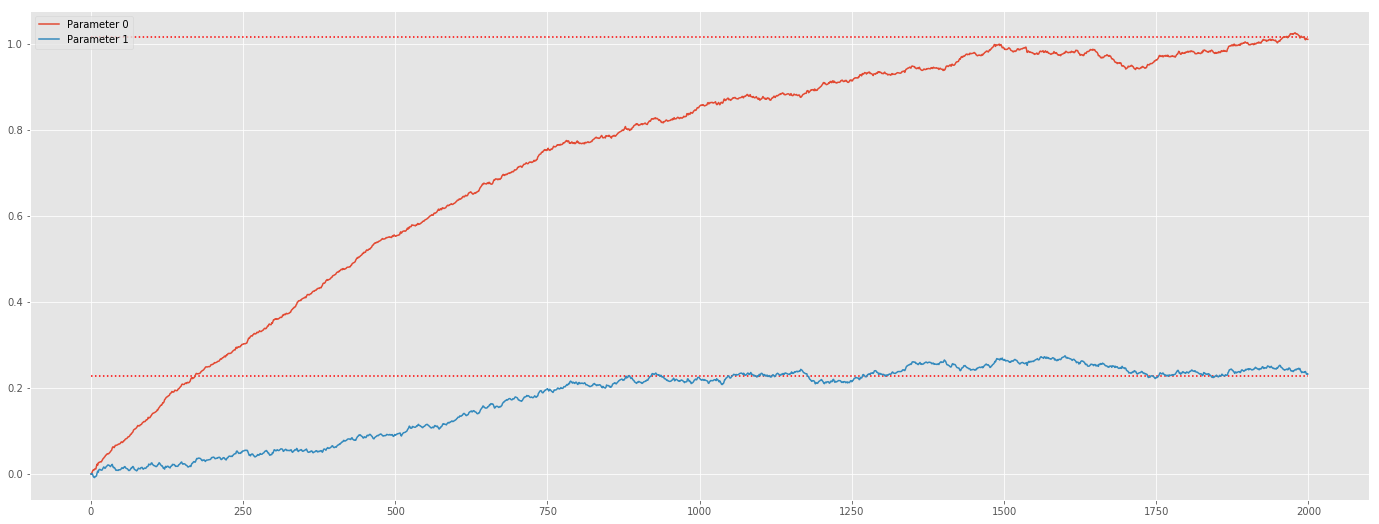

In [73]:
plt.plot(range(num_samples), xs, label="Parameter 0")
plt.plot(range(num_samples), ys, label="Parameter 1")
plt.hlines([1.01479833, 0.22752558], xmin=0, xmax=2000, linestyle=':', color='r')
plt.legend()

### 1.D.iii: RLS

In [74]:
xs = [p[0] for p in rls_weight_history]
ys = [p[1] for p in rls_weight_history]

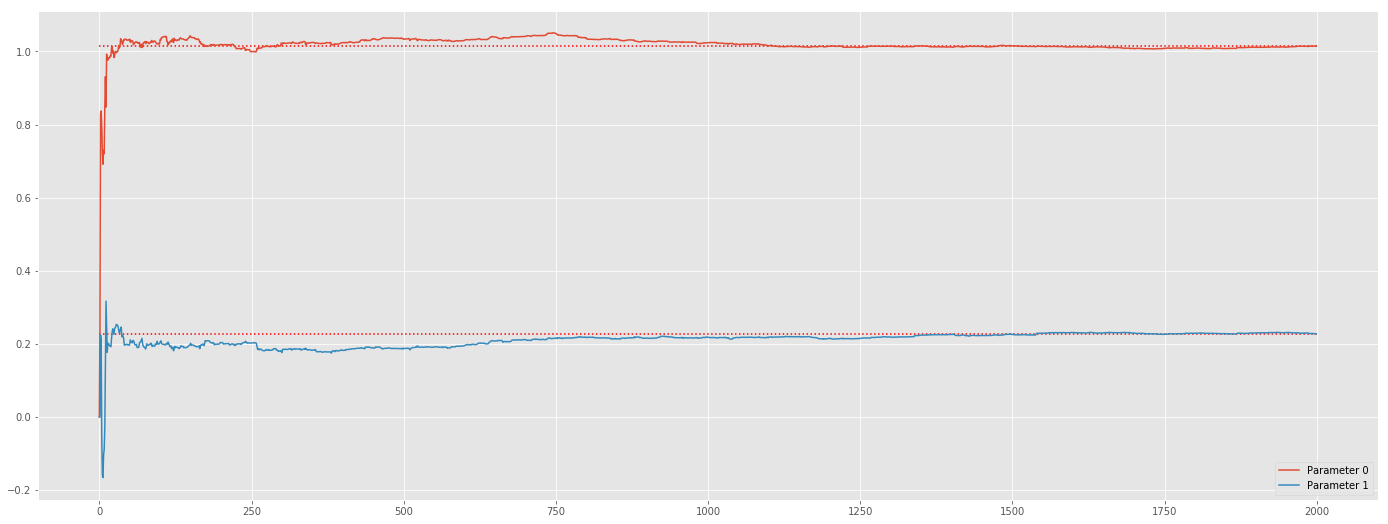

In [75]:
plt.plot(range(num_samples), xs, label="Parameter 0")
plt.plot(range(num_samples), ys, label="Parameter 1")
plt.hlines([1.01479833, 0.22752558], xmin=0, xmax=2000, linestyle=':', color='r')
plt.legend()

## 1.E parte 1 (1.A)

In [76]:
x = dados_ruido_impulsivo['x'].reshape(-1)
d = dados_ruido_impulsivo['d'].reshape(-1)

Solução de Wiener com 2 parâmetros: [0.99970688 0.19510306]


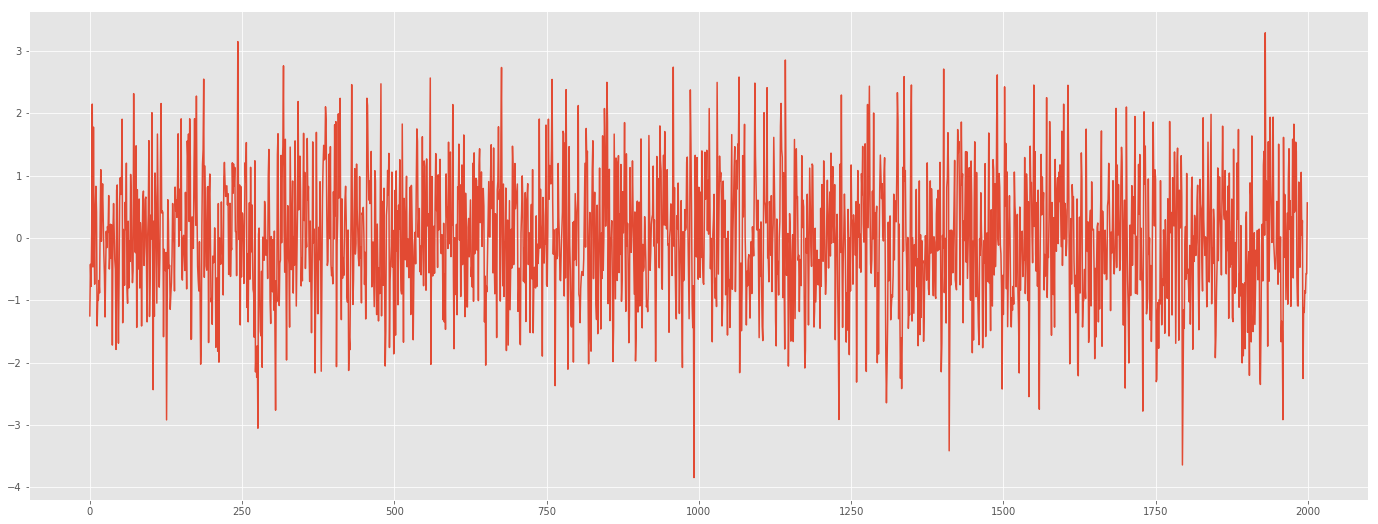

In [77]:
plt.plot(estimate_signal(x, d, 2))

## 1.E parte 2 (1.D)

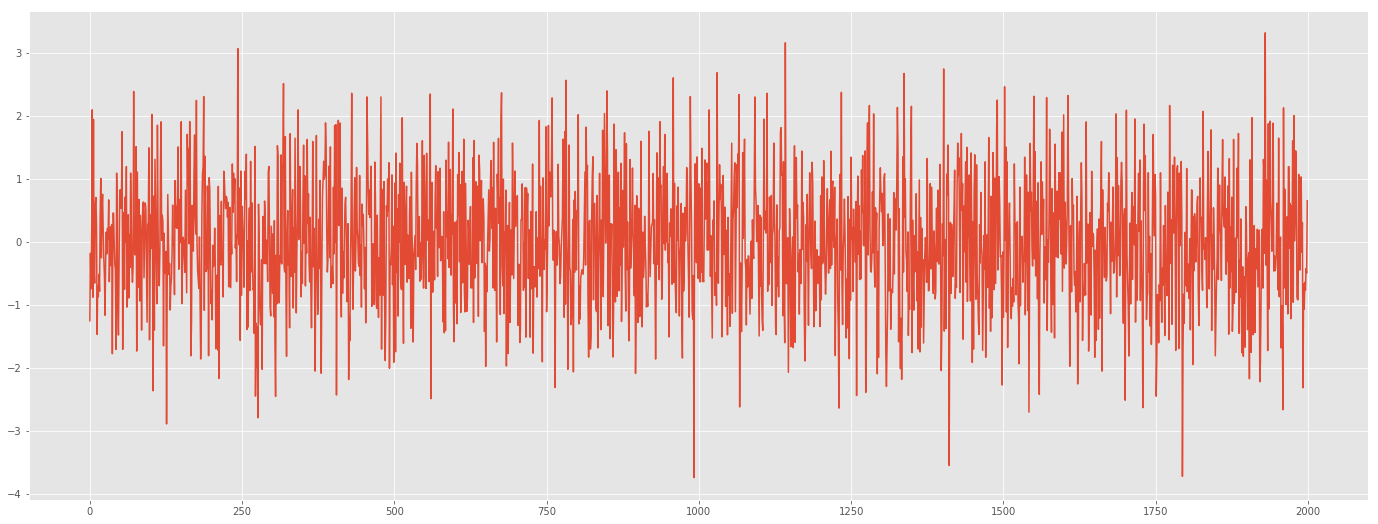

In [78]:
plt.plot(x)

### 1.D.i: LMS

In [79]:
pace = 10 / (2 * np.correlate(x, x, 'valid'))
lms_estimate, lms_weight_history = adaptive_filters.lms(x, d, 2, pace=pace)

xs = [p[0] for p in lms_weight_history]
ys = [p[1] for p in lms_weight_history]

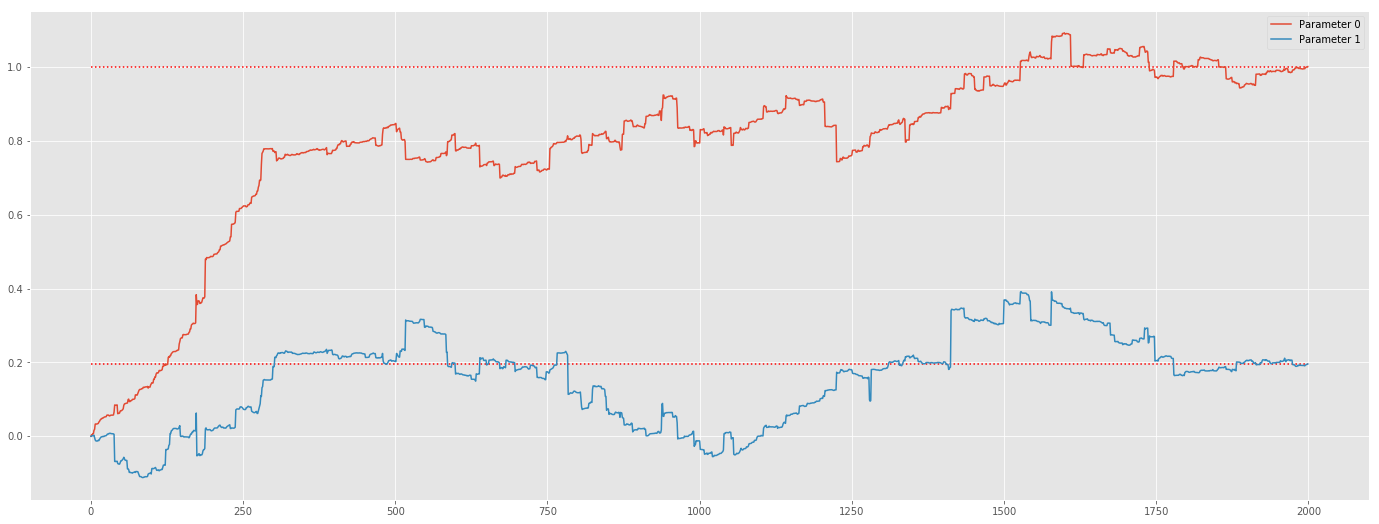

In [80]:
plt.plot(range(num_samples), xs, label="Parameter 0")
plt.plot(range(num_samples), ys, label="Parameter 1")
plt.hlines([0.99970688, 0.19510306], xmin=0, xmax=2000, linestyle=':', color='r')
plt.legend()

### 1.D.ii: Sinal do Erro

In [81]:
pace = 10 / (2 * np.correlate(x, x, 'valid'))
es_estimate, es_weight_history = adaptive_filters.error_signal_lms(x, d, 2, pace=pace)
xs = [p[0] for p in es_weight_history]
ys = [p[1] for p in es_weight_history]

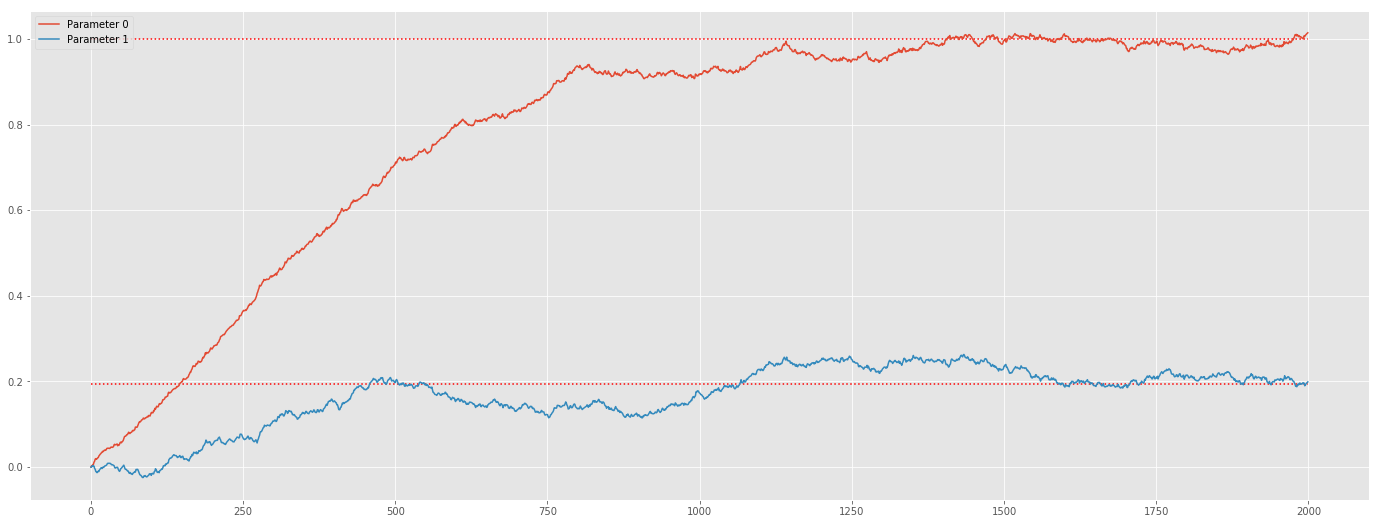

In [82]:
plt.plot(range(num_samples), xs, label="Parameter 0")
plt.plot(range(num_samples), ys, label="Parameter 1")
plt.hlines([0.99970688, 0.19510306], xmin=0, xmax=2000, linestyle=':', color='r')
plt.legend()

### 1.D.iii: RLS

In [83]:
rls_estimate, rls_weight_history = adaptive_filters.rls(x, d, 2, 1, 1)
xs = [p[0] for p in rls_weight_history]
ys = [p[1] for p in rls_weight_history]

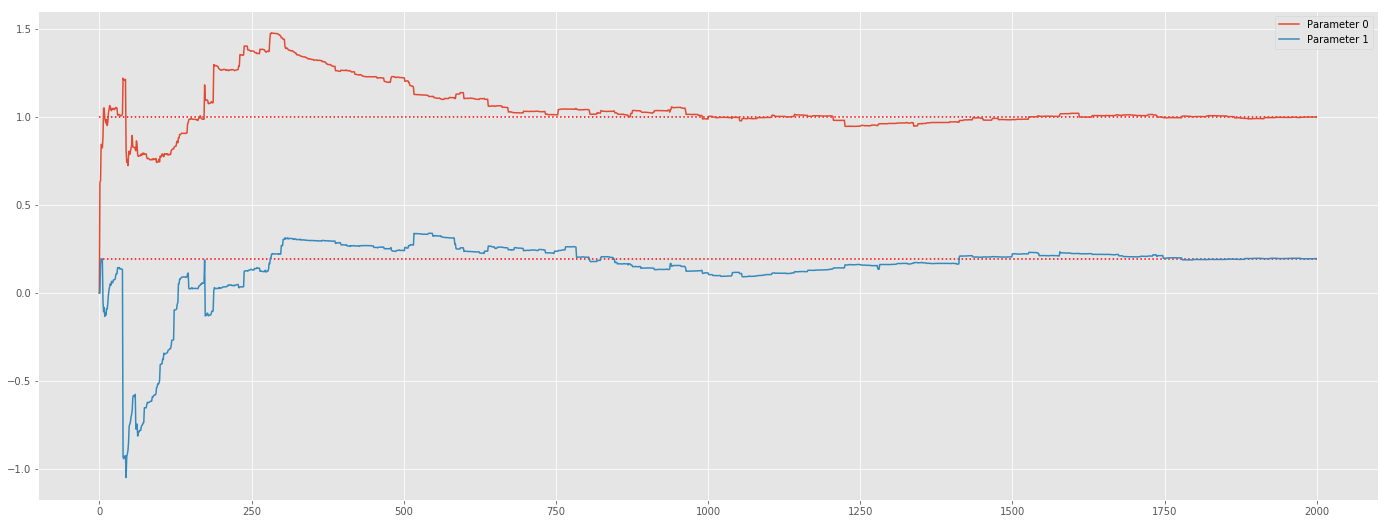

In [84]:
plt.plot(range(num_samples), xs, label="Parameter 0")
plt.plot(range(num_samples), ys, label="Parameter 1")
plt.hlines([0.99970688, 0.19510306], xmin=0, xmax=2000, linestyle=':', color='r')
plt.legend()

# 2: Fotopletismograma


In [34]:
fotopletismograma = dados_ex2['fotopletismograma'].reshape(-1)
aceleracao = dados_ex2['aceleracao'].reshape(-1)

Solução de Wiener com 2 parâmetros: [ 1.19113546e+00  2.03917296e-01  2.02744656e-01 -2.43203886e-02
 -4.18272800e-02 -4.05104554e-02 -8.98949013e-02 -7.61593983e-02
 -7.15233344e-02 -1.45918118e-02 -5.80336426e-02 -3.24405358e-02
 -2.48698030e-02  2.65656249e-02 -1.00965262e-02 -1.35696993e-02
 -3.44990667e-02 -1.90763681e-02 -2.05280789e-02 -6.75918749e-03
  2.40737105e-02 -6.69566988e-03  9.17412332e-03 -7.40528846e-03
 -2.75873382e-02  1.68290578e-02  1.66821350e-03 -4.03739218e-03
  8.15481228e-03  1.81676892e-02  2.80922508e-02  2.27272494e-02
  3.62003511e-02  1.44495387e-02  5.90198011e-02 -4.95019962e-03
  2.08538831e-02  1.11099901e-02  2.89875149e-02  3.85870341e-02
  2.49380887e-02  3.13806396e-02  1.66438368e-02  2.09176475e-02
  1.38192171e-02  4.85724014e-02  3.27950158e-02  2.25065694e-02
  5.19331904e-03  2.08422026e-02  8.67210267e-03 -1.63707295e-02
  3.76343089e-02  1.62327942e-02 -6.80002309e-04  3.07835027e-02
 -2.40800279e-02 -1.54757687e-03 -1.44626991e-02  4.15

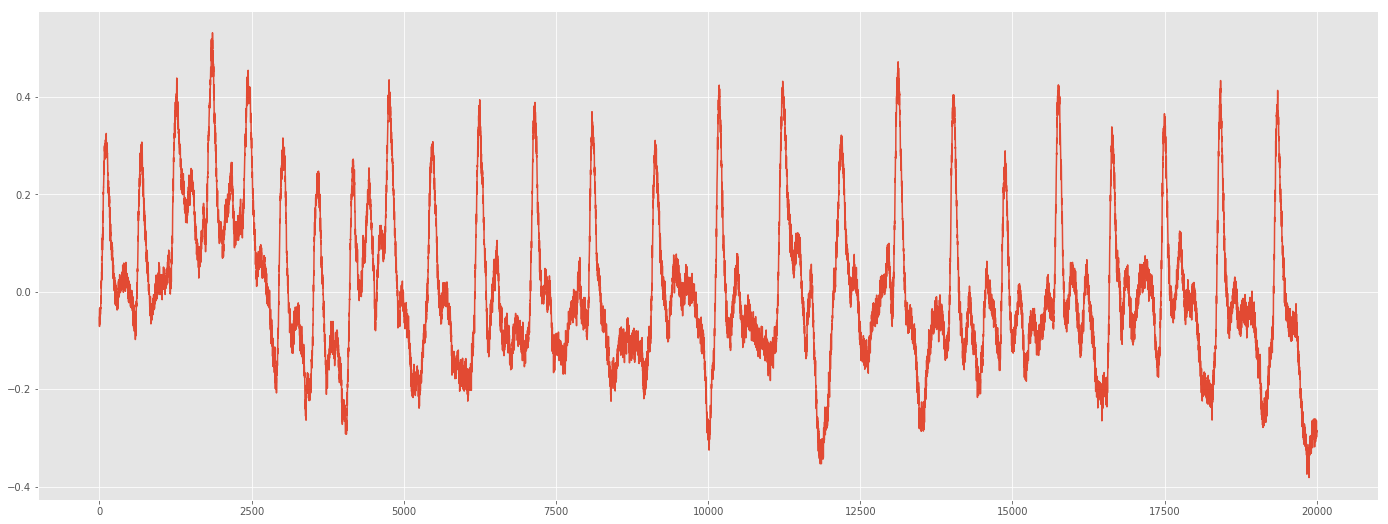

In [35]:
estimate = estimate_signal(aceleracao, fotopletismograma, 500)
plt.plot(fotopletismograma - estimate)

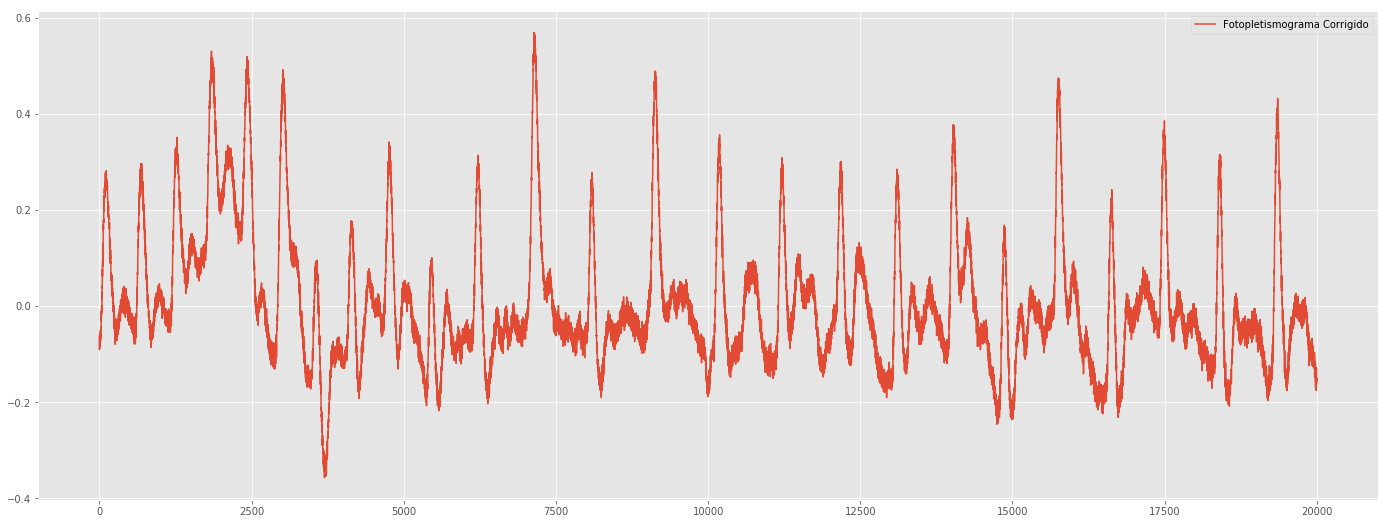

In [107]:
M = 500
pace = 3 / (4 * np.correlate(fotopletismograma, fotopletismograma, 'valid'))
estimate, hist = adaptive_filters.lms(aceleracao, fotopletismograma, M, pace)
plt.plot((fotopletismograma - estimate), label='Fotopletismograma Corrigido')
plt.legend()

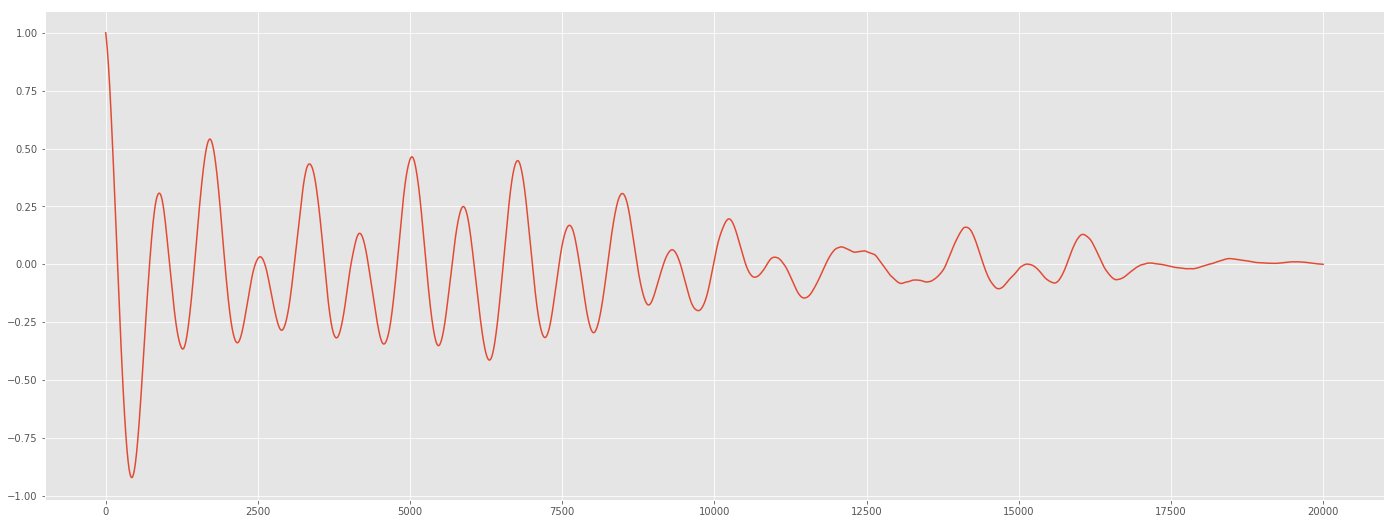

In [37]:
cross_corr = np.correlate(fotopletismograma, aceleracao, 'full')[fotopletismograma.shape[0] - 1:]
cross_corr = cross_corr / cross_corr.max()
plt.plot(cross_corr)

In [38]:
err = fotopletismograma - estimate

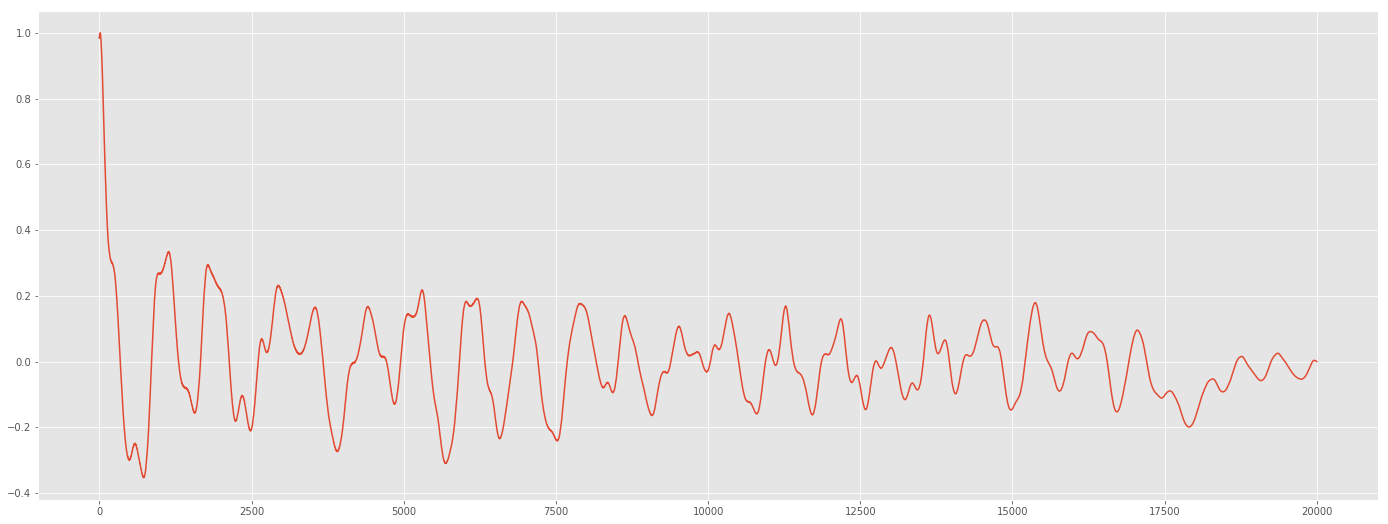

In [39]:
cross_corr = np.correlate(fotopletismograma, err, 'full')[fotopletismograma.shape[0] - 1:]
cross_corr = cross_corr / cross_corr.max()
plt.plot(cross_corr)